**Part 1: Setup and Dataset Preparation**

In [ ]:
# Import required libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize image data to range [0, 1]
x_train, x_test = x_train / 255.0, x_test / 255.0

# Convert class labels to one-hot encoding (e.g., 2 -> [0, 0, 1, 0, ..., 0])
y_train, y_test = to_categorical(y_train, 10), to_categorical(y_test, 10)

print(f"Training data shape: {x_train.shape}, Test data shape: {x_test.shape}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Training data shape: (50000, 32, 32, 3), Test data shape: (10000, 32, 32, 3)


**Part 2: Define the ResNet-18 Architecture**

In [ ]:
# Define a single residual block for ResNet
def resnet_block(input_tensor, filters, strides=1):
    # First convolutional layer
    x = layers.Conv2D(filters, (3, 3), strides=strides, padding='same', use_bias=False)(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Second convolutional layer
    x = layers.Conv2D(filters, (3, 3), strides=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    # Shortcut connection
    if strides != 1 or input_tensor.shape[-1] != filters:
        input_tensor = layers.Conv2D(filters, (1, 1), strides=strides, use_bias=False)(input_tensor)
        input_tensor = layers.BatchNormalization()(input_tensor)

    # Add the shortcut to the main path
    x = layers.Add()([x, input_tensor])
    x = layers.ReLU()(x)
    return x

# Build the full ResNet-18 model
def build_resnet18(input_shape=(32, 32, 3), num_classes=10):
    inputs = tf.keras.Input(shape=input_shape)

    # Initial convolutional layer
    x = layers.Conv2D(64, (3, 3), strides=1, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Add ResNet blocks
    x = resnet_block(x, 64)
    x = resnet_block(x, 64)

    x = resnet_block(x, 128, strides=2)
    x = resnet_block(x, 128)

    x = resnet_block(x, 256, strides=2)
    x = resnet_block(x, 256)

    x = resnet_block(x, 512, strides=2)
    x = resnet_block(x, 512)

    # Global Average Pooling and final classification layer
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Create and return the model
    model = models.Model(inputs, outputs)
    return model

**Part 3: Define the Generator for Synthetic Data**

In [ ]:
# Define a simple generator for producing synthetic images
def create_generator():
    generator = models.Sequential([
        layers.Dense(8 * 8 * 128, activation="relu", input_dim=100),
        layers.Reshape((8, 8, 128)),  # Reshape latent vector into 8x8x128 tensor
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same", activation="relu"),
        layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding="same", activation="relu"),
        layers.Conv2D(3, (3, 3), activation="tanh", padding="same")  # Output: 32x32x3 image
    ])
    return generator

# Create an instance of the generator
generator = create_generator()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Part 4: Utility Functions for Synthetic Data and Dataset Mixing**

In [ ]:
# Generate synthetic images using the generator
def generate_images(generator, num_images):
    # Generate random noise (latent vector) as input to the generator
    noise = np.random.normal(0, 1, (num_images, 100))

    # Generate synthetic images and rescale from [-1, 1] to [0, 1]
    generated_images = generator.predict(noise)
    generated_images = (generated_images + 1) / 2.0
    return generated_images

# Mix real and synthetic datasets based on a contamination ratio
def mix_datasets(real_images, real_labels, synthetic_images, synthetic_labels, ratio):
    # Calculate the number of real and synthetic samples
    num_real = int(len(real_images) * (1 - ratio))
    num_synthetic = len(real_images) - num_real

    # Combine real and synthetic data
    mixed_images = np.concatenate([real_images[:num_real], synthetic_images[:num_synthetic]])
    mixed_labels = np.concatenate([real_labels[:num_real], synthetic_labels[:num_synthetic]])

    # Shuffle the combined dataset
    indices = np.arange(len(mixed_images))
    np.random.shuffle(indices)
    return mixed_images[indices], mixed_labels[indices]

**Part 5: Generate Captions and Tokenize**
**Part 6: Build Encoder-Decoder Captioning Model**
**Part 7: Generate and Train on Mixed Datasets**



In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

def image_captioning(generator, contamination_ratios):
    # Define CIFAR-10 categories
    categories = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    # Generate simple captions based on the class labels (e.g., "A dog in the image.")
    captions = [f"A {categories[np.argmax(label)]} in the image." for label in y_train]

    # Tokenize captions: Converts words into numerical tokens
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(captions)
    vocab_size = len(tokenizer.word_index) + 1  # Vocabulary size (add 1 for padding)
    sequences = tokenizer.texts_to_sequences(captions)  # Convert text to sequences of tokens

    # Pad sequences to make them all the same length
    max_length = max(len(seq) for seq in sequences)  # Maximum length of any sequence
    captions_padded = pad_sequences(sequences, maxlen=max_length, padding='post')  # Pad with zeros at the end

    print(f"Vocabulary Size: {vocab_size}, Max Caption Length: {max_length}")

    def build_captioning_model(vocab_size, max_length):
        # Encoder: Extract features from the image using CNN
        encoder_input = layers.Input(shape=(32, 32, 3))  # Input for 32x32 CIFAR-10 images
        x = layers.Conv2D(64, (3, 3), activation='relu')(encoder_input)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Conv2D(128, (3, 3), activation='relu')(x)
        x = layers.GlobalAveragePooling2D()(x)  # Global pooling to reduce dimensions
        encoder_output = layers.Dense(256, activation='relu')(x)  # Fully connected layer for encoding

        # Decoder: Generate captions using RNN
        decoder_input = layers.Input(shape=(None,))  # Input for tokenized captions
        embedding = layers.Embedding(vocab_size, 256, mask_zero=True)(decoder_input)  # Convert tokens to dense vectors
        decoder_lstm = layers.LSTM(256, return_sequences=True)(embedding)  # Process sequences with LSTM

        # Repeat encoder output to match the caption length and combine with decoder output
        repeated_encoder_output = layers.RepeatVector(max_length)(encoder_output)
        decoder_combined = layers.Add()([
            repeated_encoder_output[:, :max_length - 1],
            decoder_lstm[:, :max_length - 1]
        ])

        # Final output: Dense layer with softmax activation for vocabulary prediction
        final_output = layers.TimeDistributed(
            layers.Dense(vocab_size, activation='softmax'))(decoder_combined)[:, :max_length - 1]

        # Combine encoder and decoder into a single model
        model = models.Model(inputs=[encoder_input, decoder_input], outputs=final_output)
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        return model

    # Build the model
    model = build_captioning_model(vocab_size, max_length)


    results = []  # List to store results for each contamination ratio

    for ratio in contamination_ratios:
        print(f"\nTraining Captioning Model with {int(ratio * 100)}% synthetic data...")

        # Generate synthetic images using the generator
        synthetic_images = generate_images(generator, len(x_train))

        # Mix real and synthetic datasets based on the contamination ratio
        x_mixed, y_mixed = mix_datasets(x_train, y_train, synthetic_images, y_train, ratio)

        # Prepare decoder inputs (tokenized captions excluding the last word)
        decoder_input_data = captions_padded[:, :-1]

        # Prepare decoder outputs (tokenized captions shifted by one word)
        decoder_output_data = captions_padded[:, 1:]
        decoder_output_data = np.expand_dims(decoder_output_data, -1)  # Add extra dimension for model compatibility

        # Train the model with the mixed dataset
        history = model.fit([x_mixed, decoder_input_data], decoder_output_data,
                            epochs=5, batch_size=64, validation_split=0.2, verbose=1)

        # Store training/validation metrics for this contamination ratio
        results.append({
            'ratio': ratio,
            'history': history.history
        })

    return results


**Part 8: Plot Training and Validation Results**

In [ ]:
def plot_captioning_results(results):
    plt.figure(figsize=(14, 6))

    # Plot Training and Validation Accuracy
    plt.subplot(1, 2, 1)
    for result in results:
        ratio = int(result['ratio'] * 100)  # Convert contamination ratio to percentage
        history = result['history']
        plt.plot(history['accuracy'], label=f"Train Acc ({ratio}%)")
        plt.plot(history['val_accuracy'], '--', label=f"Val Acc ({ratio}%)")  # Dashed line for validation accuracy
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot Training and Validation Loss
    plt.subplot(1, 2, 2)
    for result in results:
        ratio = int(result['ratio'] * 100)  # Convert contamination ratio to percentage
        history = result['history']
        plt.plot(history['loss'], label=f"Train Loss ({ratio}%)")
        plt.plot(history['val_loss'], '--', label=f"Val Loss ({ratio}%)")  # Dashed line for validation loss
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()  # Adjust layout for better readability
    plt.show()


**Part 9: Execute Task 2 and Plot Results**

Vocabulary Size: 15, Max Caption Length: 5

Training Captioning Model with 0% synthetic data...
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 187s 120ms/step
Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 148s 232ms/step - accuracy: 0.7365 - loss: 0.7768 - val_accuracy: 0.7756 - val_loss: 0.5770
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 200s 229ms/step - accuracy: 0.7753 - loss: 0.5774 - val_accuracy: 0.7756 - val_loss: 0.5769
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 200s 227ms/step - accuracy: 0.7749 - loss: 0.5769 - val_accuracy: 0.7753 - val_loss: 0.5769
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 141s 226ms/step - accuracy: 0.7747 - loss: 0.5767 - val_accuracy: 0.7744 - val_loss: 0.5760
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 141s 225ms/step - accuracy: 0.7756 - loss: 0.5763 - val_accuracy: 0.7745 - val_loss: 0.5762

Training Captioning Model with 20% synthetic data...
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 185s 118ms/step
Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 140s 223ms/step - accuracy: 0.7739 - loss: 0.5767 - val_accura

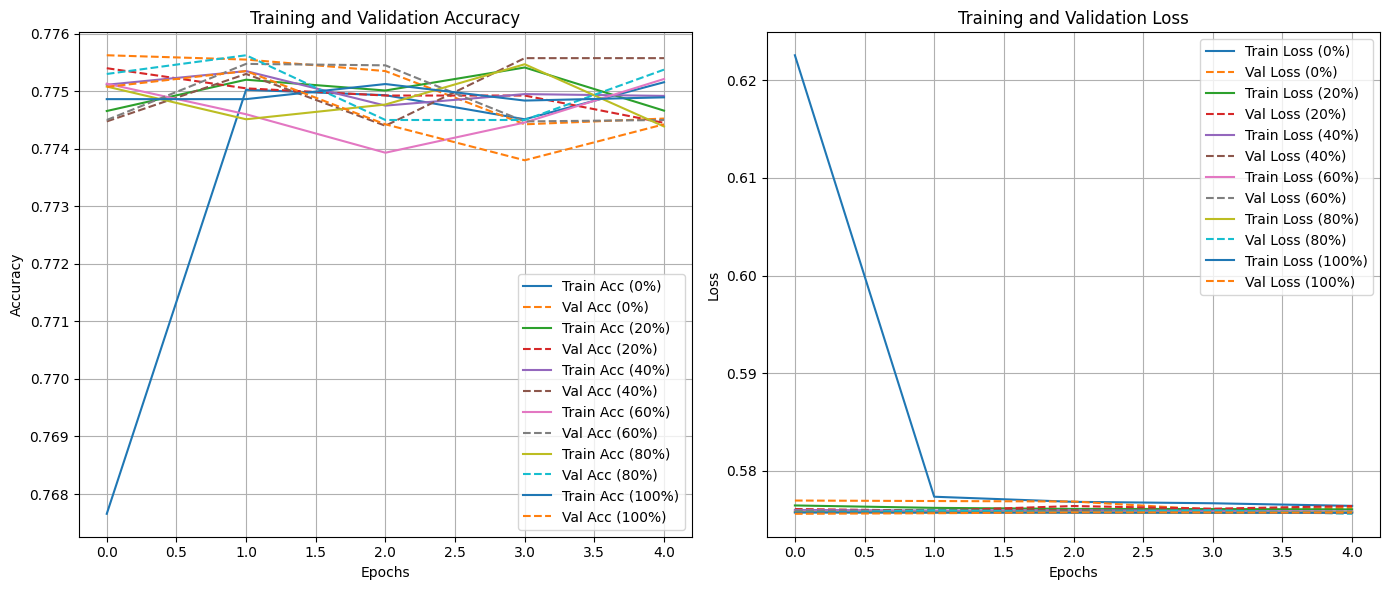

In [ ]:
# Define contamination ratios
contamination_ratios = [0, 0.2, 0.4, 0.6, 0.8, 1]

# Train the image captioning model on different contamination ratios
results = image_captioning(generator, contamination_ratios)

# Plot training and validation results
plot_captioning_results(results)
